<a href="https://colab.research.google.com/github/yugonsan/pytorch_practice/blob/main/%E7%AC%AC8%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [4]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [5]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

- 階層の深いニューラルネットワークに関する事実としては、単なる線形関数の結果を次の隠れ層の入力にするだけでなく、いくら層を深くしても1階層のモデルと数学的には変わらない
- 階層の深いNNを意味あるものにするためには、線形関数の結果に対して非線形関数と呼ばれる関数を作用させる必要がある。
- ReLuのモノマネ _/
- GPUを使おう

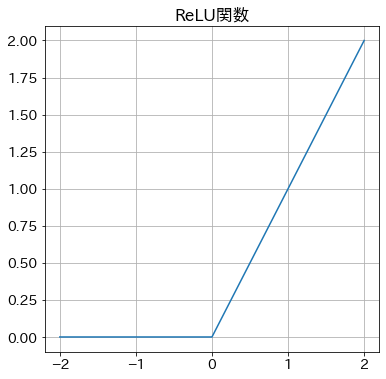

In [7]:
# ReLU関数のグラフ

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

In [6]:
# GPUチェック
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


- GPUのルール
- テンソル変数はデータがCPU/GPU上のどちらにあるかを属性として持っている
- GPUとCPUの間ではto関数で転送する
- 2つの変数がGPU上にある場合演算はGPUで行われる
- GPUとCPUにテンソルがある場合演算できないです。

In [8]:
# テスト用のtensor変数x, y
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()
print(x)
print(y)
z = x * y
print(z) 

tensor([-2.0000, -1.7500, -1.5000, -1.2500, -1.0000, -0.7500, -0.5000, -0.2500,
         0.0000,  0.2500,  0.5000,  0.7500,  1.0000,  1.2500,  1.5000,  1.7500,
         2.0000])
tensor([-1.0000, -0.7500, -0.5000, -0.2500,  0.0000,  0.2500,  0.5000,  0.7500,
         1.0000,  1.2500,  1.5000,  1.7500,  2.0000,  2.2500,  2.5000,  2.7500,
         3.0000])
tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [9]:
# 変数xをGPUに送る
x = x.to(device)
# 変数xとyの属性data,deviceの確認
print('x', x.device)
print('y', y.device)

x cuda:0
y cpu


In [10]:
# yもGPUに送る
y = y.to(device)
# GPU内で演算処理が可能
z = x * y
print(z)
# 最後にdevice='cuda:0'が表示されます

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000], device='cuda:0')


- データ前処理
- torchvision.transformsというライブラリが使いやすい
- ミニバッチ学習とは、事前に決めた数でグループ数を作り、このグループ単位で勾配計算する方法です。
- ミニバッチ学習のポイントは、グループのメンバを選ぶ際に、乱数を使うので繰り返し処理ごとに別のグループができる点です、こうすると局所最適解にとどまることを避けられる
- 全件まとめて勾配を計算する方法、バッチ学習
- グループに分割する方法、ミニバッチ学習
- データ入手：dataset、データ加工：Transofrms、ミニバッチデータセット生成：dataloaderとそれぞれのクラスがあらかじめ用意されている

In [11]:
# ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,  
    # 訓練データか検証データか
    train = True,  
    # 元データがない場合にダウンロードするか
    download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
# ダウンロードしたファイルの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 Jan 30 05:20 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Jan 30 05:20 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Jan 30 05:20 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Jan 30 05:20 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Jan 30 05:20 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Jan 30 05:20 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Jan 30 05:20 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Jan 30 05:20 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Jan 30 05:20 train-labels-idx1-ubyte.gz


In [13]:
# データ件数の確認
print('データ件数: ', len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解データの型: ', type(label))

データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解データの型:  <class 'int'>


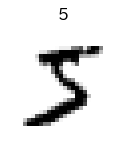

In [14]:
# 入力データの画像表示

plt.figure(figsize=(2,3))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

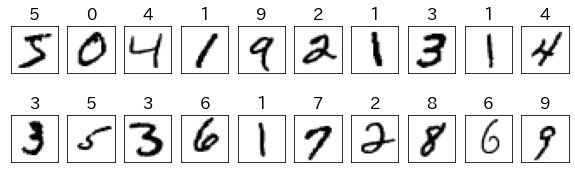

In [15]:
plt.figure(figsize=(10,3))
for i in range(20):
    ax = plt.subplot(2, 10, i+1)
    # imageとlabelの取得
    image, label = train_set0[i]
    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
# Transformsによるデータ処理
import torchvision.transforms as transforms
transform1 = transforms.Compose([
    # データのテンソル化
    transforms.ToTensor(),
])
train_set1 = datasets.MNIST(
    root=data_root, train=True, download=True, transform = transform1
)


In [17]:
# 変換結果の確認

image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [18]:
# Normalizeの利用
transform2 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    # データの正規化
    transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root, train = True, download = True, transform = transform2
)

In [19]:
# 変換結果の確認

image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [20]:
# Lambdaを利用して1階テンソル化
transform3 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    # データの正規化
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set3 = datasets.MNIST(
    root = data_root, train = True,
    download=True, transform = transform3)

In [21]:
# 変換結果の確認

image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [22]:
# データ変換用関数 Transforms
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),
    
    # (2) データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

In [23]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

In [24]:
# ミニバッチ学習の準備
from torch.utils.data import DataLoader
# ミニバッチのサイズ指定
batch_size = 500
# 訓練用のデータローダー
# 訓練用なのでシャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size, shuffle = True)
# 検証用データローダー
test_loader = DataLoader(
    test_set, batch_size = batch_size, shuffle = False)

In [25]:
# 何組のデータが取得できるか
print(len(train_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


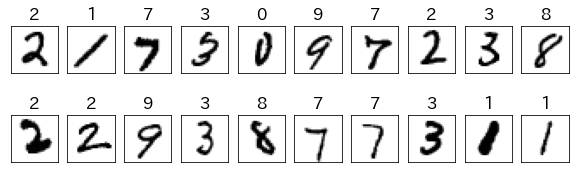

In [26]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # numpyに変換
    image = images[i].numpy()
    label = labels[i]
    
    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
# モデル定義
# 入力次元数
n_input = image.shape[0]
# 出力次元数
n_output = 10
# 隠れ層のノード数
n_hidden = 128
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [28]:
# モデルの定義
# 入力784, 出力10, 隠れ層1のNNモデル
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層の定義
        self.l1 = nn.Linear(n_input, n_hidden)
        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)
        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

- 線形関数(nn.Linear)が1つから2に増えた
- 出力層に対して活性化関数がないのは、損失関数側にsoftmax関数を含める予定だから。
- パラメタ初期値を全部1.0にする必要がない

In [29]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
# モデルのインスタンス生成
net = Net(n_input, n_output, n_hidden)
# モデルをGPUに送る
net = net.to(device)

In [30]:
# 学習率
lr = 0.01
# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()

つまり、PyTorchの関数torch.nn.CrossEntropyLoss()は、損失関数内でソフトマックス関数の処理をしたことになっているので、ロスを計算する際はニューラルネットワークの最後にソフトマックス関数を適用する必要はない。モデルの構造を汎用的にするため、モデル自体はFC層のLinearで終わるようにするためであろう。むしろ推論時にはモデルの出力にソフトマックス関数を適用することを忘れないようにしなければならない。

In [31]:
# モデル内のパラメタ確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [32]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [33]:
# モデルのサマリー表示

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [34]:
# 予測計算
# 訓練データセット、最初の1項目を取得
for images, labels in train_loader:
    print(images, labels)
    break

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor([8, 8, 0, 9, 2, 8, 0, 9, 0, 1, 0, 1, 2, 5, 7, 1, 8, 3, 1, 2, 0, 3, 7, 5,
        6, 5, 4, 0, 3, 9, 7, 6, 1, 5, 6, 5, 1, 8, 1, 1, 1, 8, 4, 3, 0, 3, 7, 1,
        2, 2, 8, 9, 3, 0, 9, 2, 0, 2, 1, 8, 0, 4, 4, 1, 3, 2, 5, 6, 7, 2, 7, 3,
        5, 0, 8, 9, 2, 9, 4, 3, 0, 5, 6, 2, 2, 5, 3, 3, 9, 6, 2, 4, 8, 7, 7, 6,
        5, 6, 0, 5, 7, 1, 9, 9, 9, 7, 3, 1, 2, 1, 6, 7, 0, 4, 8, 1, 5, 7, 9, 4,
        4, 7, 0, 4, 7, 9, 0, 1, 9, 4, 1, 1, 0, 0, 2, 3, 9, 0, 0, 5, 2, 1, 5, 5,
        3, 2, 6, 4, 2, 9, 8, 9, 2, 3, 1, 0, 7, 9, 5, 1, 5, 0, 3, 5, 3, 6, 8, 8,
        9, 1, 8, 6, 4, 2, 1, 0, 5, 3, 7, 0, 9, 9, 1, 3, 7, 4, 1, 6, 7, 6, 2, 1,
        8, 1, 0, 0, 7, 2, 0, 5, 9, 8, 8, 2, 2, 8, 1, 2, 9, 1, 5, 9, 2,

In [35]:
# データローダーから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

In [36]:
# 予測値の計算
outputs = net(inputs)
# 結果確認
print(outputs)

tensor([[-0.3622, -0.1927, -0.0179,  ...,  0.1073,  0.1025, -0.0615],
        [-0.4072, -0.1814,  0.0716,  ...,  0.1866,  0.1975,  0.1161],
        [-0.3221, -0.0547, -0.2868,  ...,  0.1967, -0.0103,  0.1591],
        ...,
        [-0.2091, -0.1058,  0.2365,  ...,  0.1360,  0.0665,  0.0987],
        [-0.2756, -0.2012,  0.1703,  ...,  0.1223,  0.2388,  0.0233],
        [-0.3045, -0.2458,  0.1416,  ...,  0.1012,  0.0820, -0.1457]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


2.3328874111175537


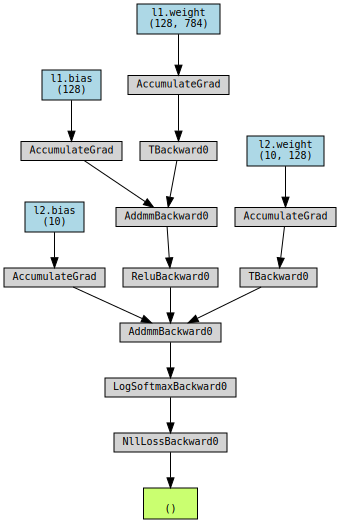

In [37]:
# 損失計算
loss = criterion(outputs, labels)
# 損失の取得
print(loss.item())
# 損失計算のグラフの可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [38]:
# 勾配計算の実行
loss.backward()

In [39]:
# 勾配計算の結果
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.00071 -0.00071 -0.00071 ... -0.00071 -0.00071 -0.00071]
 [ 0.00768  0.00768  0.00768 ...  0.00768  0.00768  0.00768]
 [-0.00179 -0.00179 -0.00179 ... -0.00179 -0.00179 -0.00179]
 ...
 [-0.00076 -0.00076 -0.00076 ... -0.00076 -0.00076 -0.00076]
 [ 0.0011   0.0011   0.0011  ...  0.0011   0.0011   0.0011 ]
 [-0.00009 -0.00009 -0.00009 ... -0.00009 -0.00009 -0.00009]]
[ 0.00071 -0.00768  0.00179  0.00085 -0.00004  0.00004  0.00135 -0.00085
  0.00254 -0.00164  0.00086 -0.00196  0.00059  0.00252 -0.00256  0.00075
  0.00605 -0.00109 -0.00177  0.00799  0.00627  0.00256 -0.00358  0.00563
 -0.00059 -0.00379  0.00343  0.      -0.00257 -0.00319 -0.00055  0.00345
  0.00175  0.00001  0.00007  0.00024  0.0047  -0.00124  0.00215  0.00183
  0.00371 -0.00607  0.00109  0.00972 -0.0017  -0.00124 -0.00044 -0.00102
 -0.00306 -0.00029 -0.0008   0.00041  0.00009 -0.00159 -0.00205 -0.00007
 -0.00059 -0.00235 -0.00043  0.00292  0.00128 -0.00846  0.0013   0.00154
  0.      -0.00055  0.00403 -0.00165 -0.0052

In [40]:
# 勾配降下法の適用
optimizer.step()

In [41]:
# パラメータ値の表示
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0278,  0.0200,  0.0316],
        [ 0.0183, -0.0322,  0.0174,  ...,  0.0088, -0.0029, -0.0034],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0323, -0.0059, -0.0169],
        [-0.0329, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True)
Parameter containing:
tensor([ 3.2475e-02, -2.9682e-02,  1.2742e-03,  1.9874e-02,  2.6836e-02,
        -2.4759e-02, -1.7201e-02, -3.5517e-02,  1.2199e-02, -4.7449e-03,
         2.1379e-02,  2.0187e-02, -2.4297e-02,  1.4928e-03, -2.7613e-02,
         2.9618e-02,  3.4051e-02, -2.2777e-02,  2.2983e-02,  3.4580e-02,
        -9.1870e-03, -3.4619e-02,  2.0599e-02, -6.0632e-03,  3.2937e-02,
         4.7784e-03,  1.7949e-02,  1.0102e-02,  1.7700e-02, -3.0853e-02,
         2.2817e-02, -2.2391e-02,  3.2049e-02,  1.7890e-0

In [45]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

In [46]:
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.82932 acc: 0.56958 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.03888 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87920


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.45883 acc: 0.87878 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.37876 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36812 acc: 0.89592 val_loss: 0.34868, val_acc: 0.90160


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35910 acc: 0.89783 val_loss: 0.34089, val_acc: 0.90220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.33336, val_acc: 0.90490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.34477 acc: 0.90135 val_loss: 0.32806, val_acc: 0.90570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33860 acc: 0.90310 val_loss: 0.32334, val_acc: 0.90710


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.33333 acc: 0.90412 val_loss: 0.31807, val_acc: 0.90790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32843 acc: 0.90520 val_loss: 0.31445, val_acc: 0.90930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.32380 acc: 0.90700 val_loss: 0.31076, val_acc: 0.91090


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31950 acc: 0.90807 val_loss: 0.30586, val_acc: 0.91190


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31587 acc: 0.90905 val_loss: 0.30281, val_acc: 0.91240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.31199 acc: 0.91032 val_loss: 0.29965, val_acc: 0.91520


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30842 acc: 0.91098 val_loss: 0.29713, val_acc: 0.91430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30507 acc: 0.91195 val_loss: 0.29432, val_acc: 0.91570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.30190 acc: 0.91320 val_loss: 0.29123, val_acc: 0.91770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29883 acc: 0.91403 val_loss: 0.28884, val_acc: 0.91700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29597 acc: 0.91492 val_loss: 0.28646, val_acc: 0.91820


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.29311 acc: 0.91662 val_loss: 0.28365, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.29027 acc: 0.91698 val_loss: 0.28185, val_acc: 0.92000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28765 acc: 0.91798 val_loss: 0.28041, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28510 acc: 0.91858 val_loss: 0.27748, val_acc: 0.92110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.28233 acc: 0.91958 val_loss: 0.27485, val_acc: 0.92180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27989 acc: 0.92040 val_loss: 0.27255, val_acc: 0.92120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27763 acc: 0.92067 val_loss: 0.27010, val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27513 acc: 0.92102 val_loss: 0.26897, val_acc: 0.92410


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.27278 acc: 0.92242 val_loss: 0.26668, val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.27048 acc: 0.92280 val_loss: 0.26462, val_acc: 0.92360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26828 acc: 0.92358 val_loss: 0.26279, val_acc: 0.92440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26597 acc: 0.92403 val_loss: 0.26075, val_acc: 0.92550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26357 acc: 0.92455 val_loss: 0.25918, val_acc: 0.92580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.26157 acc: 0.92565 val_loss: 0.25719, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25919 acc: 0.92603 val_loss: 0.25558, val_acc: 0.92630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25715 acc: 0.92695 val_loss: 0.25282, val_acc: 0.92720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25496 acc: 0.92765 val_loss: 0.25100, val_acc: 0.92940


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25292 acc: 0.92775 val_loss: 0.24995, val_acc: 0.92800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.25096 acc: 0.92845 val_loss: 0.24743, val_acc: 0.92930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24867 acc: 0.92937 val_loss: 0.24636, val_acc: 0.93070


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24664 acc: 0.92965 val_loss: 0.24402, val_acc: 0.93100


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24463 acc: 0.93042 val_loss: 0.24264, val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.24266 acc: 0.93060 val_loss: 0.24012, val_acc: 0.93220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.24070 acc: 0.93147 val_loss: 0.23928, val_acc: 0.93250


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23872 acc: 0.93212 val_loss: 0.23708, val_acc: 0.93300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23680 acc: 0.93225 val_loss: 0.23567, val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23485 acc: 0.93345 val_loss: 0.23360, val_acc: 0.93310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23294 acc: 0.93442 val_loss: 0.23177, val_acc: 0.93430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.23101 acc: 0.93478 val_loss: 0.22988, val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22909 acc: 0.93517 val_loss: 0.22863, val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22729 acc: 0.93568 val_loss: 0.22641, val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22537 acc: 0.93643 val_loss: 0.22547, val_acc: 0.93580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22367 acc: 0.93693 val_loss: 0.22324, val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.22190 acc: 0.93743 val_loss: 0.22190, val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.22019 acc: 0.93808 val_loss: 0.22011, val_acc: 0.93690


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21845 acc: 0.93840 val_loss: 0.21884, val_acc: 0.93770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21653 acc: 0.93903 val_loss: 0.21656, val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21485 acc: 0.93970 val_loss: 0.21577, val_acc: 0.93910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21321 acc: 0.94003 val_loss: 0.21334, val_acc: 0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.21152 acc: 0.94050 val_loss: 0.21216, val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20996 acc: 0.94112 val_loss: 0.21143, val_acc: 0.93960


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20826 acc: 0.94157 val_loss: 0.20924, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20673 acc: 0.94210 val_loss: 0.20716, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20500 acc: 0.94235 val_loss: 0.20682, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20353 acc: 0.94292 val_loss: 0.20485, val_acc: 0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.20198 acc: 0.94355 val_loss: 0.20380, val_acc: 0.94120


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.20053 acc: 0.94373 val_loss: 0.20211, val_acc: 0.94110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19892 acc: 0.94420 val_loss: 0.20087, val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19754 acc: 0.94453 val_loss: 0.19895, val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19587 acc: 0.94513 val_loss: 0.19793, val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19454 acc: 0.94533 val_loss: 0.19671, val_acc: 0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19313 acc: 0.94565 val_loss: 0.19520, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.19163 acc: 0.94620 val_loss: 0.19405, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.19041 acc: 0.94635 val_loss: 0.19304, val_acc: 0.94360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18891 acc: 0.94713 val_loss: 0.19190, val_acc: 0.94340


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18764 acc: 0.94737 val_loss: 0.19039, val_acc: 0.94470


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18620 acc: 0.94795 val_loss: 0.18892, val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18487 acc: 0.94812 val_loss: 0.18786, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18358 acc: 0.94818 val_loss: 0.18690, val_acc: 0.94610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18228 acc: 0.94888 val_loss: 0.18556, val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.18101 acc: 0.94955 val_loss: 0.18461, val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17976 acc: 0.94977 val_loss: 0.18364, val_acc: 0.94700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17846 acc: 0.95025 val_loss: 0.18184, val_acc: 0.94720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17737 acc: 0.95042 val_loss: 0.18089, val_acc: 0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17612 acc: 0.95097 val_loss: 0.17952, val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17488 acc: 0.95118 val_loss: 0.17919, val_acc: 0.94800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17383 acc: 0.95140 val_loss: 0.17744, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17264 acc: 0.95175 val_loss: 0.17635, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.17143 acc: 0.95218 val_loss: 0.17556, val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.17035 acc: 0.95275 val_loss: 0.17470, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16915 acc: 0.95272 val_loss: 0.17389, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16811 acc: 0.95332 val_loss: 0.17414, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16696 acc: 0.95357 val_loss: 0.17145, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.16583 acc: 0.95408 val_loss: 0.17067, val_acc: 0.94960


In [47]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.32629 精度: 0.74660
最終状態: 損失: 0.17067 精度: 0.94960


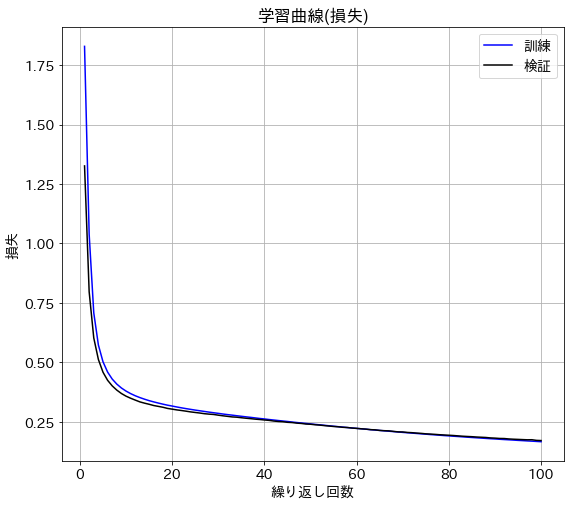

In [48]:
# 学習曲線の表示 (損失)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

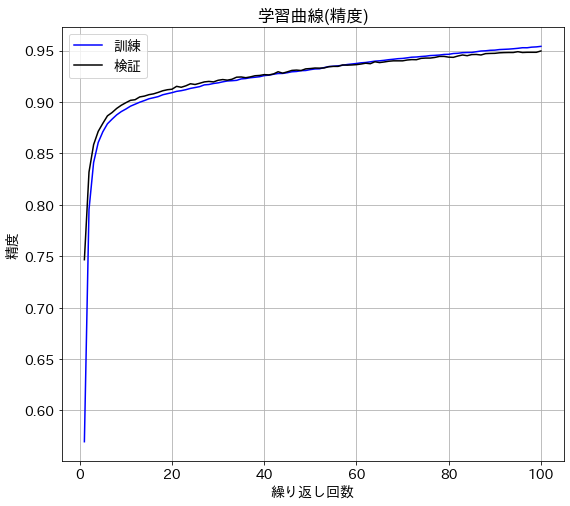

In [49]:
# 学習曲線の表示 (精度)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [50]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

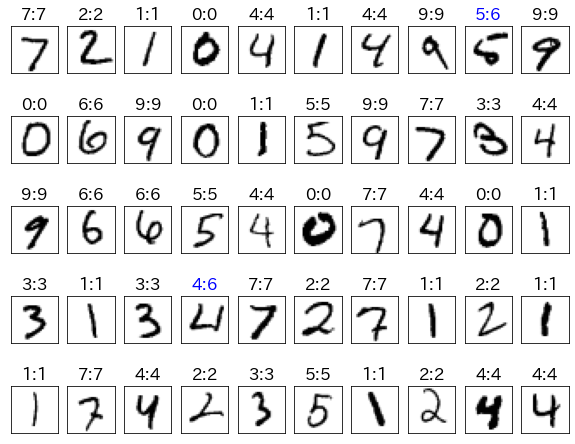

In [51]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2
    
  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

隠れ層を2層にすると効果はあった